# Project: Stock Price Prediction

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression

### Overall Goal

Predict stock price (high) on day X+1 as precisely as possible.

### Data Import And Cleaning

In [15]:
#get data

path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)
df = df.iloc[::-1] #reverse df order

df.head()

,Date,Close/Last,Open,High,Low
2530,02/24/2014,1847.61,1836.78,1858.71,1836.78
2529,02/25/2014,1845.12,1847.66,1852.91,1840.19
2528,02/26/2014,1845.16,1845.79,1852.65,1840.66
2527,02/27/2014,1854.29,1844.90,1854.53,1841.13
2526,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [64]:
def plot_chart(df, col): # Plotting the col against dates
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))
    num_args = len(col)

    for ind in range(num_args):
        ax.plot(df['Date'], df[col[ind]])

    ax.set_title('Plot of price over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show() 

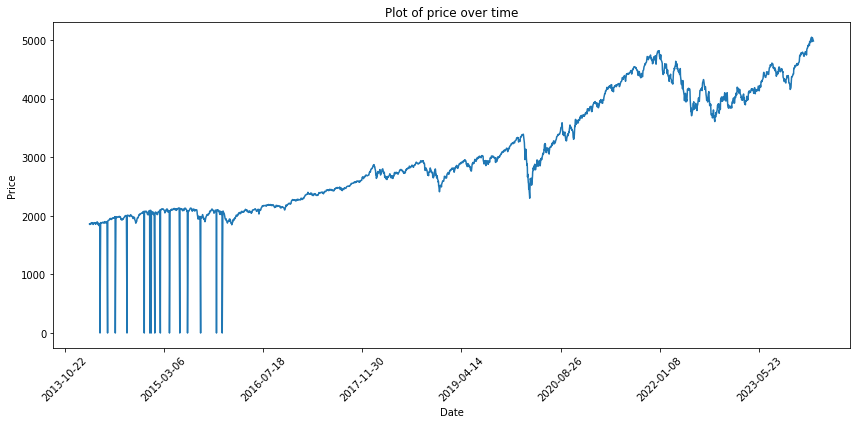

In [65]:
plot_chart(df, ["High"])

In [66]:
#remove data before june 2016
df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[df['Date'] >= '05/31/2016']

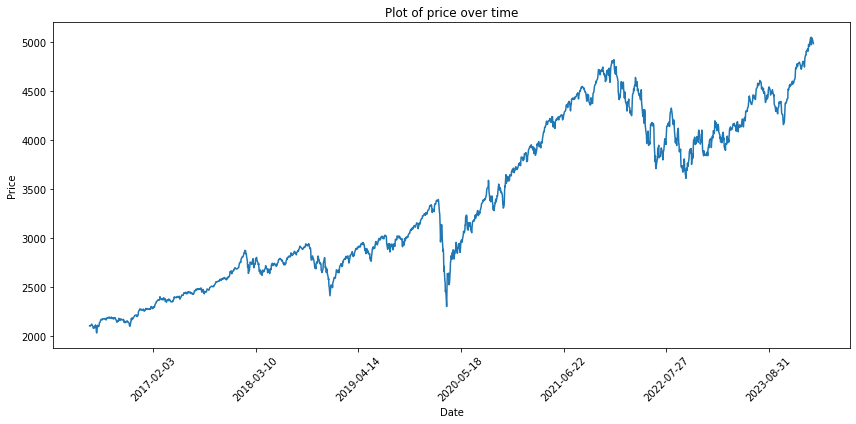

In [67]:
plot_chart(df_filtered, ["High"])

### 1. Linear Regression

In [68]:
#Technique 1: Linear Regression
#fit model to the last X days
#use model to predict price on day X+1
#eval

model = LinearRegression()

stock_prices = df_filtered["High"].values
X = 5
predicted_stock_prices = [0] * X

for ind, _ in enumerate(stock_prices): #loop over daily highs
    if ind >= len(stock_prices) - X:
        break
    prices = stock_prices[ind:ind + X] #get X highs (label)
    days = np.arange(X).reshape(-1, 1) #X days (feature)
    model.fit(days, prices) #fit model to training examples
    y_pred = model.predict(np.array(X + 1).reshape(-1, 1)) #predict on day X+1
    predicted_stock_prices.append(round(y_pred[0], 2)) 

predicted_stock_prices = np.array(predicted_stock_prices)
df_filtered_ext = df_filtered.copy()
df_filtered_ext["log_reg_pred"] = predicted_stock_prices
print(df_filtered_ext.head)

<bound method NDFrame.head of            Date  Close/Last     Open     High      Low  log_reg_pred
1944 2016-05-31     2096.96  2100.13  2103.48  2088.66          0.00
1943 2016-06-01     2099.33  2093.94  2100.97  2085.10          0.00
1942 2016-06-02     2105.26  2097.71  2105.26  2088.59          0.00
1941 2016-06-03     2099.13  2104.07  2104.07  2085.36          0.00
1940 2016-06-06     2109.41  2100.83  2113.36  2100.83          0.00
...         ...         ...      ...      ...      ...           ...
4    2024-02-14     5000.62  4976.44  5002.52  4956.45       5006.33
3    2024-02-15     5029.73  5003.14  5032.72  4999.44       4988.73
2    2024-02-16     5005.57  5031.13  5038.70  4999.52       5000.78
1    2024-02-20     4975.51  4989.32  4993.71  4955.02       5035.54
0    2024-02-21     4981.80  4963.03  4983.21  4946.00       5040.19

[1945 rows x 6 columns]>


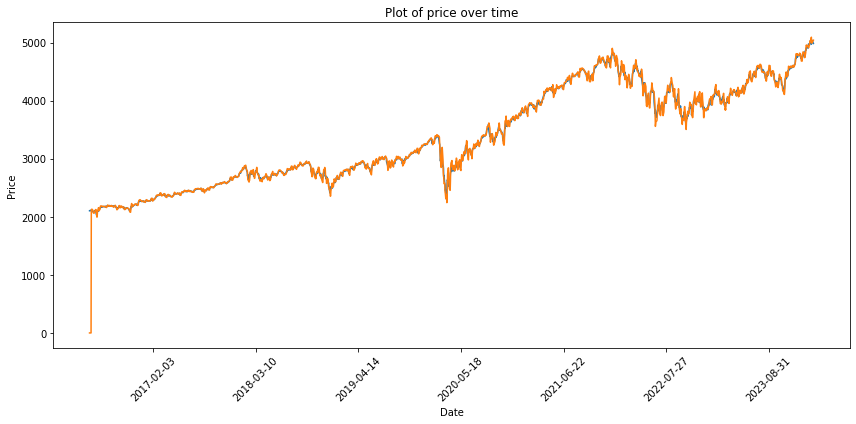

In [71]:
plot_chart(df_filtered_ext[100:200], ["High", "log_reg_pred"])

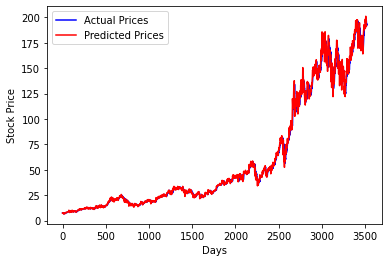

: 

In [55]:
# Plot the actual stock prices in blue
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(stock_prices, color='blue', label='Actual Prices')

# Plot the predicted prices in red
plt.plot(predicted_stock_prices, color='red', label='Predicted Prices')

# Add labels and legend
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.show()